In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [2]:
import os
import glob
import numpy as np
import pandas as pd
import shutil
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [22]:
os.chdir('/content/drive/My Drive/project_captcha/dataset/processed')

In [ ]:
files = sorted(glob.glob('*.jpg'))

## Deskewing letters

In [87]:
def find_contours(im):

    contours, hierarchy = cv2.findContours(im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # print(contours)
    contours = sorted(contours, key=lambda ctr: cv2.contourArea(ctr), reverse=True)[:5]
    good_cnts = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
    cv2.drawContours(im, good_cnts, -1, (0,0,255), 0)
    return good_cnts


In [88]:
def get_mini_boxes(contour):
    rect = cv2.minAreaRect(contour)
    points = sorted(list(cv2.boxPoints(rect)), key=lambda x: x[0])
    width, height = rect[1]
    angle = rect[2]
    if abs(angle)==0.0 or abs(angle)==90.0:
        angle = 0.0
    else:
        if height>width:
            if angle < -48:
                angle = (-90 - angle)
            else:
                angle = angle
        else:
            if angle < -48:
                angle = (90+angle)
            else:
                angle = -angle

    index_1, index_2, index_3, index_4 = 0, 1, 2, 3
    if points[1][1] > points[0][1]:
        index_1 = 0
        index_4 = 1
    else:
        index_1 = 1
        index_4 = 0
    if points[3][1] > points[2][1]:
        index_2 = 2
        index_3 = 3
    else:
        index_2 = 3
        index_3 = 2

    box = [points[index_1], points[index_2], points[index_3], points[index_4]]
    return box, angle


In [89]:
def crop_rect(img, rect):
    
    # Rotation
    center = rect[0]
    size = rect[1]
    angle = rect[2]
    center, size = tuple(map(int, center)), tuple(map(int, size))

    # get row and col num in img
    height, width = img.shape[0], img.shape[1]
    # print(height,width)
    M = cv2.getRotationMatrix2D(center, angle, 1)
    img_rot = cv2.warpAffine(img, M, (width, height), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return img_rot

In [90]:
def padding(im,exp_size=(100,80)):
    exp_height, exp_width = exp_size
    height, width = im.shape[0], im.shape[1]

    del_ht = exp_height-height
    del_wd = exp_width-width

    pad_top = del_ht//2
    pad_bottom = del_ht - pad_top

    pad_left = del_wd//2
    pad_right = del_wd - pad_left

    img_padded = cv2.copyMakeBorder(im, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)
    # print(img_padded.shape)
    return img_padded


1000_89W6U.jpg
1001_79JKQ.jpg
1002_424KM.jpg
1003_Z833Q.jpg
1004_7VH32.jpg
1005_U2RV3.jpg
1006_JF738.jpg
1007_46UH7.jpg
1008_3QJRT.jpg
1009_T3H8C.jpg
100_79GPY.jpg
1010_3G4E7.jpg
1011_WC94G.jpg
1012_K867W.jpg


error: ignored

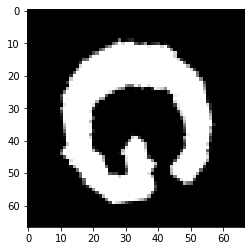

In [93]:

for file in files:
    frame = []
    print(file)
    im = cv2.imread(file,-1)
    ret,thresh_inv = cv2.threshold(im,127,255,cv2.THRESH_BINARY_INV)
    image_copy = thresh_inv.copy()
    good_cnts = find_contours(image_copy)
    letters = []
    k=0
    for cnt in good_cnts:
        box, angle = get_mini_boxes(cnt)
        box = np.int0(box)

        origin_x = min(box[0][0],box[1][0],box[2][0],box[3][0])
        origin_y = min(box[0][1],box[1][1],box[2][1],box[3][1])
        # print(origin_x,origin_y)
        max_x = max(box[0][0],box[1][0],box[2][0],box[3][0])
        max_y = max(box[0][1],box[1][1],box[2][1],box[3][1])
        # print(max_x,max_y)

        width = max_x - origin_x
        height = max_y - origin_y
        centre = (width/2, height/2)
        rect = (centre,(height, width),(angle))
        img = thresh_inv[origin_y:max_y, origin_x:max_x]
        img_rot = crop_rect(img,rect)
        img_padded = padding(img_rot)
        letters.append(img_padded)

    plt.imshow(img_rot, cmap='gray')

    frame = letters[0]
    for i in range(1,len(letters)):
        frame = cv2.hconcat([frame,letters[i]])
    
    cv2.imwrite('../deskewed/'+file+'.jpg',frame)
